# Driven composite systems and interface with QuTiP

B. McDonough

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

Systems of interests for quantum computing generally involve mutual coupling between multiple quantum systems. By driving these individual sybsystems, we can perform single- or multi-qubit gates.

In the context of superconducting circuits, a common method of driving a circuit is to capacitively couple a voltage bias to one or multiple nodes of the circuit. By a proper choice of drive frequency , amplitude and envelope, logical operations can be achieved.

The popular Python package QuTiP can be used to simulate the time dynamics of quantum systems. For the simulation of superconducting circuits, scQubits provides an easy and transparent interface to QuTiP through the `HilbertSpace` class. A tutorial on the usage of the HilbertSpace class can be found [here](https://github.com/scqubits/scqubits-examples/blob/master/examples/demo_hilbertspace.ipynb). 

## Composite systems in scQubits
A system consisting of several coupled subsystems can be represented using a Hamiltonian of the form

$$ 
H = \sum_{i}H_0^{(i)} + \sum_{ij}H_1^{(ij)}
$$

where $i,j$ both index over the subsystems. Here, $H_0^{(i)}$ is the "bare" Hamiltonian of the $i^\text{th}$ subsystem, only acting nontrivially on this subsystem. 

The Hamiltonian modeling subsystem $i$ coupling to subsystem $j$ is $H_1^{(ij)}$, which similarly only acts nontrivially on these two subsystems. Capacitive coupling between a qubit and a resonator, which is one standard method of coupling qubits, results in a coupling Hamiltonian of the form $H_1^{(ij)} = g_{ij}\hat n_i (a_j + a^{\dagger}_j)$, where $\hat n_i$ is the charge operator for the $i^\text{th}$ qubit and $a_j, a_j^\dagger$ are the annihilation and creation operators respectively for the $j^\text{th}$ resonator. In the following we will consider the dispersive regime, where $g_{ij}$ is relatively small compared to the frequency difference $\Delta_{ij}$ between the oscillator and the qubit.

scQubits models such a system by first diagonalizing each $H_0^{(i)}$ and expressing each subsystem operator in the diagonal basis. Tensor products of these eigenstates $| \vec n\rangle = |n_1\rangle_1 \otimes |n_2\rangle_2 \otimes ... \otimes |n_N\rangle_N$, known as the "bare" eigenstates, are used to write the Hamiltonian $H' =  \sum_{i}H_0^{(i)} + \sum_{ij}H_1^{(ij)}$ as a matrix by computing 
$$\langle \vec n | H | \vec m \rangle
 = \sum_i E_{n_i}^{(i)}+ \langle \vec n |\sum_{ij}H^{(ij)} | \vec m \rangle
 $$
 for each vector of indices $\vec n,\vec m$. Lastly, these matrix elements are used to numerically diagonalize $H'$, obtaining the "dressed" eigenstates of the coupled system and the corresponding energy levels.

## Driving Operators
The effect of a time-dependent voltage introduced at one or more of the nodes of the circuit can be taken into account through the addition of a term to the Hamiltonian:
$$
H' = H + \sum_i H_d^{(i)}
$$
The term $H_d^{(i)}$ only acts nontrivially on the $i^\text{th}$ subsystem, and for a capacitively coupled voltage drive it takes the form $H_d = \varepsilon_i(t)\hat n_i$, where $\hat n_i$ is the charge number operator for the $i^\text{th}$ subsystem.

## Example: Fluxonium coupled to a resonator

The Hamiltonian of a fluxonium qubit can be written as
$$
H_0 ^{(f)}= 4E_C \hat n_f^2 - E_J \cos(\hat\phi_f-\varphi_{ext})+\frac{1}{2}E_L\hat\phi_f^2 \ .
$$
The Hamiltonian of a resonator is 
$$
H_0^{(r)}= E_{osc}a^\dagger a \ ,
$$
where scQubits uses frequency in GHz as the standard units for energy, effectively setting $h = 1$, and constant term is customarily dropped. The Hamiltonian modeling these two subsystems and their interaction is
$$
H' = H_{0}^{(f)} + H_{0}^{(r)} + g\hat n_r(a+a^\dagger)
$$
scQubits is able to represent such a coupled system and diagonalize it for an appropriate choice of $g$. The process for doing so is shown below:

## Set up Hilbert space

Following the procedure described in the scQubits tutorial, we can represent this Hamiltonian $H$ using a `HilbertSpace` object. This class is the main way to symbolically represent coupled systems in scQubits, and it also is one of the main points of exposure between the scQubits API and QuTiP.

In [16]:
import scqubits as scq
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt

In [17]:
qbt = scq.Fluxonium(
    EJ = 8.9,
    EC = 2.5,
    EL = 0.5,
    flux = 0.33,
    cutoff = 110
)

osc = scq.Oscillator(
    E_osc=5.7,
    truncated_dim=5,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength = 0.2,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

# Drive operators
The drive Hamiltonians $H_d^{(i)}$, as discussed, are proportional to the charge number operators $\hat n_i$. These operators are generally off-diagonal with respect to the dressed eigenbasis. In order to simulate the evolution of the system with qutip, these operators first need to be expressed in this basis.

The representation of $\hat n_i$ in the bare energy eigenbasis of the $i^\text{th}$ subsystem can be safely truncated to a level specified by a cutoff parameter in the constructor of the object, since the anharmonicity of the qubit will allow high-lying energy levels to be safely neglected. This offers a speedup for computing the matrix elements in the dressed eigenbasis, which accounts for the contribution of the coupling terms to the energy eigenstates.

In [18]:
#populate the dictionaries with the choice of eigenstates
hilbertspace.generate_lookup()

In [19]:
def dressed_index(hilbertspace, *states):
    """A method to get a dressed index from a list of bare indices by subsystem. 
    Intended to take the responsibility away from the user to know the order of the
    subsystems within HilbertSpace

    Returns: Integer representing the dressed index most closely matching the input product state
    """

    states_by_index = list(sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states]))
    return hilbertspace.dressed_index(list(zip(*states_by_index))[1])[0]

def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, expecially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    #Get bare eigenvectors of subsystem stored in hilbertspace
    hilbertspace.bare_eigenstates(subsystem)
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    #Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    #Get full dressed eigenbasis
    evecs, = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

### Compute charge operators
This method can now be used to express both charge operators acting on the full system in the dressed energy eigenbasis:

In [20]:
#the phi_r operator can be used for a resonator, and the specification of g depends on which is being used
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)

## Driving Simulation in QuTIP
Now that the operators are obtained in the dressed eigenbasis, qutip's `sesolve` or `mesolve` functionality can be used to simulate the time dynamics associated with driving the system. In the case of the Fluxonium, the $\hat n$ operator acts like a $\sigma_x$ operator on the first two energy eigenstates, transitioning between them. We may drive transitions between these two states by choosing the drive frequency $\omega_d$ to be the resonant frequency of the qubit.

The drive can either be applied to the qubit directly or to the resonator. Since the frequency of the resonator is detuned from the frequency of the qubit, the qubit may be driven directly without creating photons in the resonator, and virtual excitations can be created in the resonator to drive the qubit.

In [21]:
s0_idx = dressed_index(hilbertspace, (osc, 0),(qbt,0))
s1_idx = dressed_index(hilbertspace, (osc, 0),(qbt,1))

In [22]:
Omega = 2*np.pi*.01 #Drive strength in GHz

#0-1 transition frequency of the qubit
wd = hilbertspace.energy_by_dressed_index(s1_idx)[0] - hilbertspace.energy_by_dressed_index(s0_idx)[0]

#time-dependent drive e(t) on resonance
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(wd*t)

#use precomputed evals to get diagonal hamiltonian
evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*hilbertspace.subsystem_count)
H_qbt_drive = [diag_dressed_hamiltonian,[n_qbt, drive_coeff]]

In [23]:
#hilbertspace.bare_productstate will not necessarily correspond, use this method instead
state0 = qt.basis(hilbertspace.dimension, s0_idx)
state1 = qt.basis(hilbertspace.dimension, s1_idx)

tlist = np.linspace(0, 1900, 1900) #total time to simulate, number of time steps
result = qt.sesolve(H_qbt_drive, state0, tlist, e_ops = [state0*state0.dag(), state1*state1.dag()], args = {"omega_d": wd})

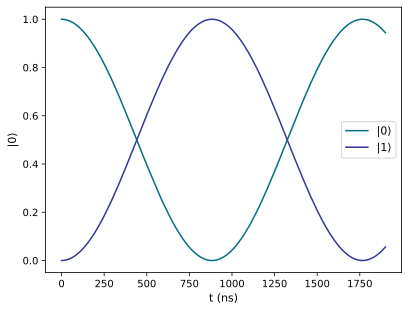

In [24]:
plt.plot(tlist, result.expect[0], label=r"$|0\rangle$")
plt.plot(tlist, result.expect[1], label=r"$|1\rangle$")
plt.xlabel(r"t (ns)")
plt.ylabel(r"$|0\rangle$");
plt.legend()

### Driving through the resonator
By using the phase operator (or equivalently the charge operator) for the resonator, transitions in the qubit can be driven through the resonator. Due to the weak coupling, this transition will occur more slowly than in driving the qubit directly.

In [27]:
Omega = 2*np.pi*.02 #Choosing a stronger drive than used for directly driving qubit

#Still driving at the |0> -> |1> transition frequency
wd = hilbertspace.energy_by_dressed_index(dressed_index(hilbertspace, (qbt,1),(osc,0)))[0] - hilbertspace.energy_by_dressed_index(dressed_index(hilbertspace,(qbt,0),(osc,0)))[0]

#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
H_osc_drive = [diag_dressed_hamiltonian,[phi_r, drive_coeff]]

In [28]:
tlist = np.linspace(0, 10000, 5000) #Will take a longer time for the pi-pulse to complete
result = qt.sesolve(H_osc_drive, state0, tlist, e_ops = [state0*state0.dag(), state1*state1.dag()], args = {"omega_d": wd})

The same $\pi$ pulse will be effectuated on the qubit by the drive on the resonator, but the time the pulse takes is longer due to the smaller matrix element $\langle 00 | \hat \phi_{r} |10 \rangle$ compared to $\langle 00 | \hat n{qbt} |10 \rangle$.

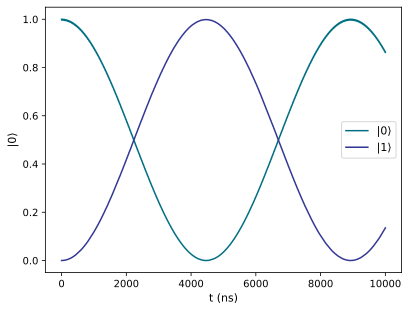

In [29]:
plt.plot(tlist, result.expect[0], label=r"$|0\rangle$")
plt.plot(tlist, result.expect[1], label=r"$|1\rangle$")
plt.xlabel(r"t (ns)")
plt.ylabel(r"$|0\rangle$");
plt.legend()

## Example 2: Fluxonium initialization procedure
The lower frequency of Fluxonium causes it to relax to a mixed state, so it requires an active reset procedure. The energy of the mixed state cannot be changed through unitary operations, so the coupling to a noisy resonator affected by photon loss provides the nonunitary operation needed to remove entropy from the fluxonium. This can be accomplished through the initialization procedure described in [this](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010) paper by Zhang et Al. 

An this procedure, the fluxonium starts out near to the completely mixed state $\rho = \frac{1}{2}(|g\rangle \langle g| +|e\rangle \langle e|)\otimes |0\rangle$. A $\pi$ pulse drives the population of $|g0\rangle$ to $|h0\rangle$, then another pulse is used to drive $|h0\rangle$ to $|e1\rangle$. Lastly, the system equilibriates with most of the population in $|e1\rangle$ transitioning to $|e0\rangle$ due to photon loss in the resonator, preparing $|e0\rangle$ with high fidelity.

In [30]:
#experimental values borrowed from 
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010
qbt = scq.Fluxonium(
    EJ = 3.395,
    EC = .479,
    EL = .132,
    flux = .5,
    cutoff = 110,
    truncated_dim = 7
)

osc = scq.Oscillator(
    E_osc=5.7,
    truncated_dim=5,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

g=.2
hilbertspace.add_interaction(
    g_strength = g,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

hilbertspace.generate_lookup()

In [31]:
#resonator drive operator
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)

The dressed eigenstates correspond closely to the bare product states since the coupling is weak. The `dressed_index` function matches a tensor product state to the corresponding dressed eigenstate.

In [32]:
g0 = dressed_index(hilbertspace, (qbt, 0 ),(osc, 0))
e0 = dressed_index(hilbertspace, (qbt, 1), (osc, 0))
h0 = dressed_index(hilbertspace, (qbt, 3), (osc, 0))
e1 = dressed_index(hilbertspace, (qbt, 1), (osc, 1))

In [36]:
Omega1 = .2 #These parameteres optimized through simulation
T1 = 245 #time to drive g0 -> h0
Omega2 = .15 
T2 = 10000 #time to drive h0 -> e1

#g0 -> h0 transition
w1 = hilbertspace.energy_by_dressed_index(h0)[0] - hilbertspace.energy_by_dressed_index(g0)[0]
#h0 -> e1 transition
w2 = hilbertspace.energy_by_dressed_index(e1)[0] - hilbertspace.energy_by_dressed_index(h0)[0]-.00008 #TODO: where is this coming from?

#drive amplitude as a function of time
def drive_coeff(t, args):
    if t < T1:
        return Omega1*np.cos(w1*t)
    elif t < T1+T2:
        return Omega2*np.cos(w2*t)
    else:
        return 0

evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*2)
H_qbt_drive = [diag_dressed_hamiltonian,[phi_r, drive_coeff]]

In [37]:
states = [qt.basis(hilbertspace.dimension,i) for i in [g0,e0,h0,e1]]
#reshape states to be compatible with Hamiltonian for mesolve
states = [qt.Qobj(state.data.toarray(), dims = [hilbertspace.subsystem_dims,[1,1]]) for state in states]

In [39]:
kappa = .0003
a_osc = basis_change(osc.annihilation_operator(), osc, hilbertspace)

#initial mixed state
thermal_state = .5*(states[0]*states[0].dag() + states[1]*states[1].dag())
tlist = np.linspace(0, 19000, 6000) #total time
result = qt.mesolve(
    H_qbt_drive, #hamiltonian
    thermal_state, #initial density matrix
    tlist,
    e_ops = [state * state.dag() for state in states], #expectation values
    c_ops = [np.sqrt(kappa)*a_osc], #collapse operators
)

Text(0, 0.5, 'population')

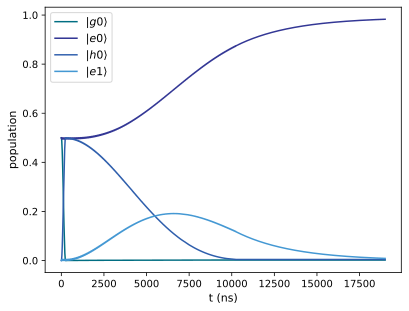

In [40]:
plt.plot(tlist, result.expect[0], label = r"$|g0\rangle$")
plt.plot(tlist, result.expect[1], label = r"$|e0\rangle$")
plt.plot(tlist, result.expect[2], label = r"$|h0\rangle$")
plt.plot(tlist, result.expect[3], label = r"$|e1\rangle$")
plt.legend()
plt.xlabel("t (ns)")
plt.ylabel("population")

In [41]:
print("Fidelity:", result.expect[1][-1])

Fidelity: 0.9829078602788361
